In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [33]:
import sklearn
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.preprocessing import FunctionTransformer, LabelEncoder, Normalizer, StandardScaler, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin, clone
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score,train_test_split
from scipy import stats
from sklearn.linear_model import LinearRegression
from scipy.special import boxcox1p


In [34]:
data_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

In [35]:
data_df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [36]:
data_df['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

<Axes: >

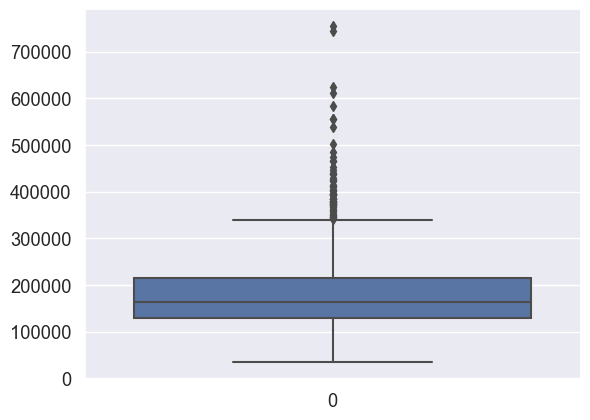

In [37]:
sns.boxplot(data_df['SalePrice'])

<Axes: xlabel='SalePrice', ylabel='Count'>

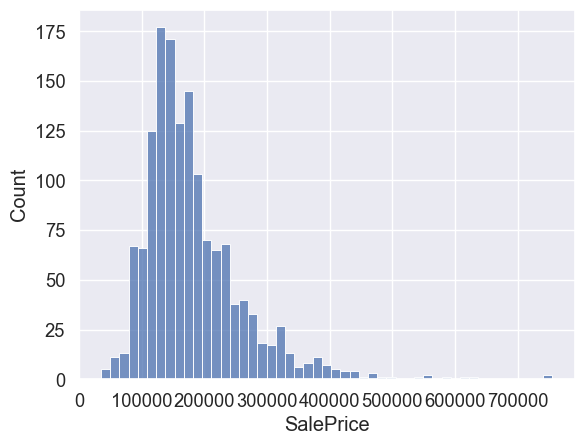

In [38]:
sns.histplot(data_df['SalePrice'])

In [39]:
data_df['SalePrice'].skew()

1.8828757597682129

In [40]:
# log transformation in order to make saleprice more normal
data_df['SalePrice'] = np.log1p(data_df['SalePrice'])

In [41]:
data_df['SalePrice'].skew()

0.12134661989685333

Text(0.5, 1.0, 'After Log Trans')

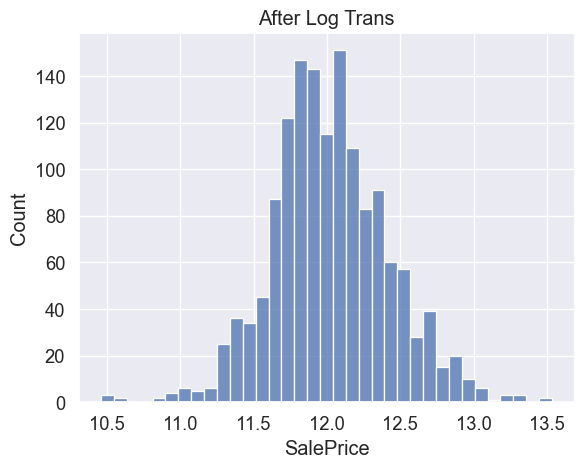

In [42]:
sns.histplot(data_df['SalePrice'])
plt.title("After Log Trans")

In [43]:
y_train = data_df['SalePrice']

### so now to understand what happened
#### 1. first we read the data then start looking at the cols 
#### 2. find the prediction target, plot it make it middle-skewed
#### 3. then assign it to the label (Y)

In [44]:
col_nan = data_df.isna().sum() / data_df.shape[0]

Text(0.5, 1.0, 'features and nan values in them')

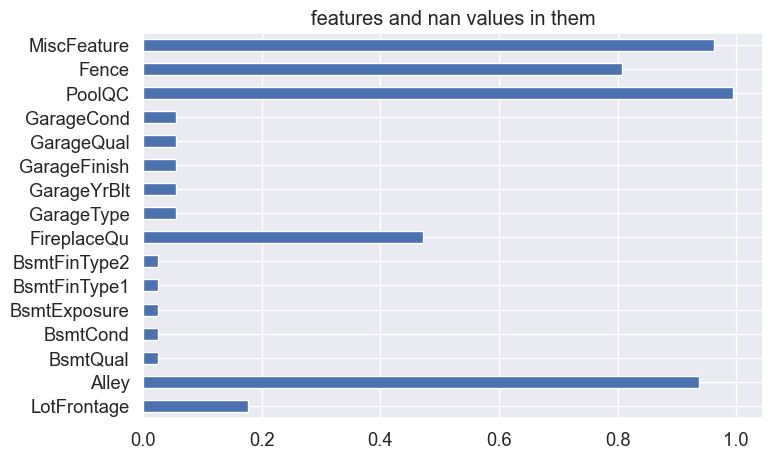

In [45]:
plt.figure(figsize=(8, 5))
sns.set(font_scale=1.2)
col_nan[col_nan > 0.01].plot(kind = "barh")
plt.title("features and nan values in them")

In [46]:
# remove id col
data_df = data_df.drop('Id', axis=1)
test_df = test_df.drop('Id', axis=1)

In [47]:
# Removing columns that contain the same value in 100% (Street and Utilities)
data_df = data_df.drop(['Street', 'Utilities'], axis=1)
test_df = test_df.drop(['Street', 'Utilities'], axis=1)

In [51]:
def remove_outliers(dataset, threshold, columns=None, removed=False):
    """ 
    Z-score method.
    Function returns a dataframe without rows labeled as 'outliers' according to the given threshold.  
    ---------------
    If columns = None, transform all numerical columns.
    If removed = True, return also dataframe with removed rows.
    """
    if columns is None:
        numerics = ['int64', 'float64']
        columns = dataset.select_dtypes(include=numerics).columns
    
    tmp = dataset.copy()
    z = np.abs(stats.zscore(tmp[columns]))
    outliers = (z > threshold).any(axis=1)  # Check if any value in a row exceeds the threshold
    outliers_idxs = tmp.index[outliers].tolist()
    
    print("Number of removed rows = {}".format(len(outliers_idxs)))
    
    if removed:
        return dataset.drop(outliers_idxs), tmp.loc[outliers]
    else:
        return dataset.drop(outliers_idxs)


In [53]:
# clear_data is a dataframe with train data after removing outliers

clear_data, removed_data = remove_outliers(data_df, threshold=3, removed=True, columns=['GrLivArea'])

Number of removed rows = 16


In [56]:
# Concatenate all data together - both train and test
train_ = clear_data.drop(['SalePrice'], axis=1)
all_data = pd.concat([data_df, test_df]).reset_index(drop=True)

In [57]:
print("Is there YearBuilt more than 2017 ? : ", all_data[all_data.YearBuilt > 2017].count()[0] != 0)
print("Is there GarageYrBlt more than 2017 ? : ", all_data[all_data.GarageYrBlt > 2017].count()[0] != 0)

Is there YearBuilt more than 2017 ? :  False
Is there GarageYrBlt more than 2017 ? :  True


In [58]:
all_data[all_data.GarageYrBlt > 2017].GarageYrBlt #It seems like it is a typo

2592    2207.0
Name: GarageYrBlt, dtype: float64

In [59]:
all_data.loc[2590, 'GarageYrBlt'] = 2007

In [61]:
neigh_lot_frontage = all_data.groupby('Neighborhood')['LotFrontage'].agg(["mean", "median"])
neigh_lot_frontage['avg_mean_median'] = (neigh_lot_frontage['mean'] + neigh_lot_frontage['median'] )/ 2
neigh_lot_frontage

,mean,median,avg_mean_median
Neighborhood,,,
Blmngtn,46.900000,43.0,44.950000
Blueste,27.300000,24.0,25.650000
BrDale,21.500000,21.0,21.250000
BrkSide,55.789474,51.0,53.394737
ClearCr,88.150000,80.5,84.325000
CollgCr,71.336364,70.0,70.668182
Crawfor,69.951807,70.0,69.975904
Edwards,66.910112,65.0,65.955056
Gilbert,74.207207,64.0,69.103604


In [66]:
# transformation into medians
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

In [67]:
# Transformation of some numerical variables that are actually categorical.

In [64]:
def convert_to_string(df, columns):
    df[columns] = df[columns].astype(str)
    return df

In [68]:
num_to_categ_features = ['MSSubClass', 'OverallCond']#, 'YrSold', 'MoSold']

all_data = convert_to_string(all_data, columns = num_to_categ_features)

In [69]:
# Replacing missing values in the rest of numerical columns